In [38]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [18]:
# Baixe os dados históricos de preços de ações da Apple (AAPL)
ticker_symbol = "AAPL"
start_date = "2010-01-01"
end_date = "2020-12-31"
data = yf.download(ticker_symbol, start=start_date, end=end_date)
data = data['Close'].values

[*********************100%%**********************]  1 of 1 completed


In [21]:
def training_test_data():
    training_size = int(len(data)*0.84)  ## ~1 year as Training | change for exact training dataset
    train_data = data[:training_size]
    test_data = data[training_size:]
    return train_data, test_data

train_data, test_data = training_test_data()
print(train_data.shape, test_data.shape)

(2325,) (443,)


In [28]:
## Data Transformation, its better to normalize the data to get good results in the Neural Network
scaler = MinMaxScaler().fit(train_data.reshape(-1, 1))

train_scaled = scaler.transform(train_data.reshape(-1, 1))
test_scaled = scaler.transform(test_data.reshape(-1, 1))

In [30]:
## Now create an input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
    Xs = np.array(Xs)
    ys = np.array(ys)
    return np.reshape(Xs,(Xs.shape[0],Xs.shape[1])), np.reshape(ys,ys.shape[0])

LOOK_BACK = 7 # Correct according to model / hypertuning

X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
print('X_train.shape:', X_train.shape)
print('y_train.shape:', y_train.shape)
print('X_test.shape:', X_test.shape) 
print('y_test.shape:', y_test.shape)

X_train.shape: (2318, 7)
y_train.shape: (2318,)
X_test.shape: (436, 7)
y_test.shape: (436,)


In [34]:
svr = SVR(kernel='rbf' , C=68e3, gamma=0.0001)
svr.fit(X_train, y_train)
svr_predict = svr.predict(X_test)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
svr_predict = scaler.inverse_transform(svr_predict.reshape(-1, 1))

In [36]:
svr_predict.shape

(436, 1)

In [39]:
def evaluation(test, predicted):
    # Calculating and printing the R2 value
    r2 = r2_score(test, predicted)
    print("R2 Value of sequential model:", round(r2, 3))

    # Calculating and printing the MAE score
    mae = mean_absolute_error(test, predicted)
    print("Mean Absolute Error:", round(mae, 2))

    # Calculating and printing the MSE score
    mse = mean_squared_error(test, predicted)
    print("Mean Squared Error:", round(mse, 2))

evaluation(y_test, svr_predict)

R2 Value of sequential model: 0.89
Mean Absolute Error: 7.04
Mean Squared Error: 75.12


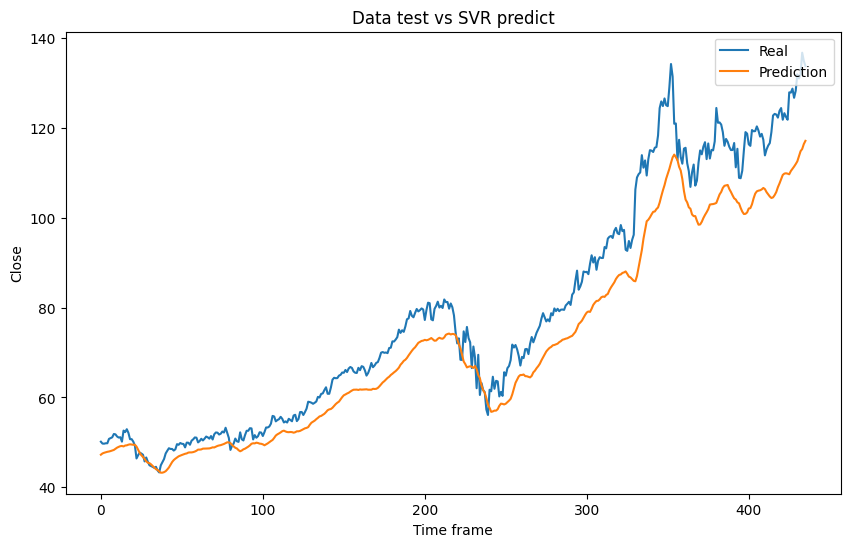

In [43]:

plt.figure(figsize = (10, 6))
plt.plot(y_test)
plt.plot(svr_predict)
plt.title("Data test vs SVR predict")
plt.ylabel("Close")
plt.xlabel("Time frame")
plt.legend(["Real", "Prediction"], loc="upper right")